A modified version of Jeremy's notebook for Practical Deep Learning for Coders: Part 2 Lesson 12. Additional notes were added, together with new sections for the 'homework'. This includes an implementation of K-Means Clustering from scratch.

You may find that the code has excessive comments and other beginner issues (e.g., print statements rather than logging). This workbook represents my personal notes on the course and is not really intended to be a (nicely composed) blog post or tutorial.

The original unmodified notebook is available on the [FastAI courses GitHub site](https://github.com/fastai/courses), specifically [here:](https://github.com/fastai/courses/blob/master/deeplearning2/meanshift.ipynb)

# Clustering

Clustering techniques are unsupervised learning algorithms that try to group unlabelled data into "clusters", using the (typically spatial) structure of the data itself. It has many [applications](https://en.wikipedia.org/wiki/Cluster_analysis#Applications).

The easiest way to demonstrate how clustering works is to simply generate some data and show them in action. We'll start off by importing the libraries we'll be using today.

Source: [FastAI notebook](https://github.com/fastai/courses/blob/master/deeplearning2/meanshift.ipynb)

In [1]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial

In [2]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

## Create data

In [3]:
n_clusters=6
n_samples =250 # per cluster

To generate our data, we're going to pick 6 random points, which we'll call centroids, and for each point we're going to generate 250 random points about it.

In [4]:
centroids = torch.rand(n_clusters, 2) * 70 - 35 # creates uniform random variable between -35 and 35. 
# This will multiply each element by 70 to scale tensor from 0 to 70, then minus 35, resulting in a distribtion between -35 and 35.

In [5]:
centroids.shape

torch.Size([6, 2])

In [6]:
centroids

tensor([[ 26.759,  29.050],
        [ -8.200,  32.151],
        [ -7.669,   7.063],
        [-17.040,  20.555],
        [ 30.854, -25.677],
        [ 30.422,   6.551]])

In [7]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [8]:
def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))
# where m is the mean; here the covariance matrix is a diagonal matrix with 5 on the diagonals.

In [9]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

Below we can see each centroid marked w/ X, and the coloring associated to each respective cluster.

In [10]:
def plot_data(centroids, data, n_samples, ax=None, title=None): 
    # modified Jeremy's function to add a title when specified.
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)
    if title:
        ax.set_title(title)

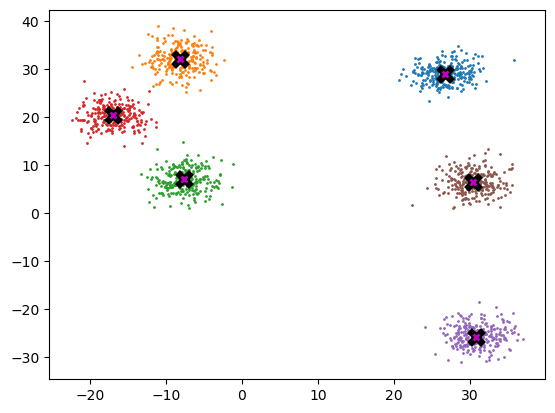

In [11]:
plot_data(centroids, data, n_samples)

## Mean shift

Most people that have come across clustering algorithms have learnt about **k-means**. Mean shift clustering is a newer and less well-known approach, but it has some important advantages:
* It doesn't require selecting the number of clusters in advance, but instead just requires a **bandwidth** to be specified, which can be easily chosen automatically
* It can handle clusters of any shape, whereas k-means (without using special extensions) requires that clusters be roughly ball shaped.

The algorithm is as follows:
* For each data point x in the sample X, find the distance between that point x and every other point in X
* Create weights for each point in X by using the **Gaussian kernel** of that point's distance to x
    * This weighting approach penalizes points further away from x
    * The rate at which the weights fall to zero is determined by the **bandwidth**, which is the standard deviation of the Gaussian
* Update x as the weighted average of all other points in X, weighted based on the previous step

This will iteratively push points that are close together even closer until they are next to each other.

Source: [FastAI notebook](https://github.com/fastai/courses/blob/master/deeplearning2/meanshift.ipynb)

In [12]:
midp = data.mean(0) # mid-point
midp

tensor([ 9.222, 11.604])

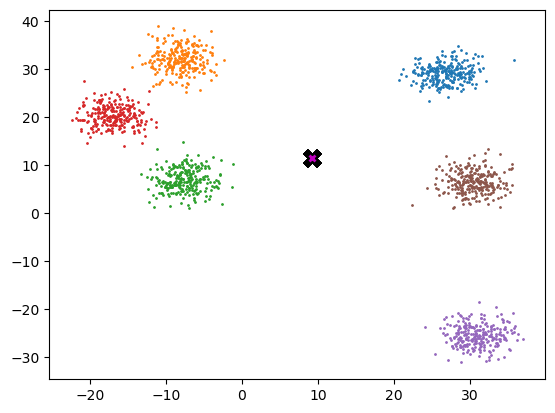

In [13]:
plot_data([midp]*6, data, n_samples)

Definition of the gaussian kernel:

In [14]:
def gaussian(d, bw): return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))
# where d is distance and bw is the bandwidth

In [15]:
def plot_func(f):
    x = torch.linspace(0,10,100)
    plt.plot(x, f(x))

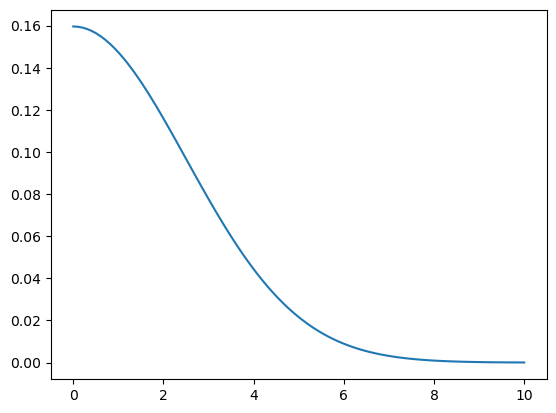

In [16]:
plot_func(partial(gaussian, bw=2.5))

In our implementation, we choose the bandwidth to be 2.5. 

One easy way to choose bandwidth is to find which bandwidth covers one third of the data.

In [17]:
def tri(d, i): return (-d+i).clamp_min(0)/i # triangular weighting. It's a simpler function, we will compare with gaussian. 

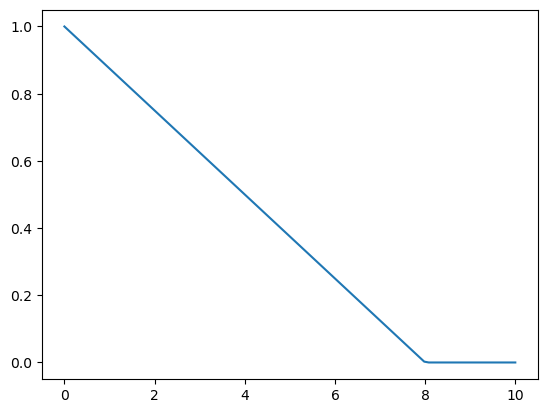

In [18]:
plot_func(partial(tri, i=8))

In [19]:
X = data.clone() # clone used, as we will be shifting the points towards the center
x = data[0] # lowercase x - first invidual point; matrix is capital X

In [20]:
x

tensor([26.204, 26.349])

In [21]:
x.shape,X.shape,x[None].shape #  None adds an additional axis.

(torch.Size([2]), torch.Size([1500, 2]), torch.Size([1, 2]))

In [22]:
(x[None]-X)[:8]

tensor([[ 0.000,  0.000],
        [ 0.513, -3.865],
        [-4.227, -2.345],
        [ 0.557, -3.685],
        [-5.033, -3.745],
        [-4.073, -0.638],
        [-3.415, -5.601],
        [-1.920, -5.686]])

In [23]:
(x-X)[:8] # This will work without the extra axis, because last axis matches and second last doesn't exist, so will be ok for broadcasting

tensor([[ 0.000,  0.000],
        [ 0.513, -3.865],
        [-4.227, -2.345],
        [ 0.557, -3.685],
        [-5.033, -3.745],
        [-4.073, -0.638],
        [-3.415, -5.601],
        [-1.920, -5.686]])

*Video paused for break at approx. 56:30 min*

In [24]:
# rewrite using torch.einsum
dist = ((x-X)**2).sum(1).sqrt() # dist = euclidian distance
dist[:8]

tensor([0.000, 3.899, 4.834, 3.726, 6.273, 4.122, 6.560, 6.002])

## Einsum Homework

**torch.einsum example syntax (for batch matrix multiplication)**

Note lowercase b = batch size
```
As = torch.randn(3, 2, 5)
Bs = torch.randn(3, 5, 4)
torch.einsum('bij,bjk->bik', As, Bs)

tensor([[[-1.0564, -1.5904,  3.2023,  3.1271],
        [-1.6706, -0.8097, -0.8025, -2.1183]],

        [[ 4.2239,  0.3107, -0.5756, -0.2354],
        [-1.4558, -0.3460,  1.5087, -0.8530]],

        [[ 2.8153,  1.8787, -4.3839, -1.2112],
        [ 0.3728, -2.1131,  0.0921,  0.8305]]])
```

In [25]:
# Homework
dif = x-X
dist_homework = torch.einsum('ij,ij->i', dif, dif).sqrt()
dist_homework[:8]

tensor([0.000, 3.899, 4.834, 3.726, 6.273, 4.122, 6.560, 6.002])

Let's check to see if the entire output of the homework function is that same as Jeremy's code, not only the 8 values listed above.

In [26]:
print("Total number of values that are close:", torch.isclose(dist, dist_homework).sum().item())
print("Are all values close?", torch.isclose(dist, dist_homework).all().item()) # NB, there is an .allclose() we can use instead!

Total number of values that are close: 1500
Are all values close? True


*Continue video at approx 1:04:30*

In [27]:
weight = gaussian(dist, 2.5)
weight

tensor([    0.160,     0.047,     0.025,  ...,     0.000,     0.000,     0.000])

In [28]:
weight.shape,X.shape # shapes don't match

(torch.Size([1500]), torch.Size([1500, 2]))

In [29]:
weight[:,None].shape # add unit axis. We will want weights for each x and y value.

torch.Size([1500, 1])

In [30]:
weight[:,None]*X # we can now multiply by X (then later divide by the sum of the weights to create weighted average)

tensor([[    4.182,     4.205],
        [    1.215,     1.429],
        [    0.749,     0.706],
        ...,
        [    0.000,     0.000],
        [    0.000,     0.000],
        [    0.000,     0.000]])

In [31]:
# Put the above into one function to perform one update step
def one_update(X):
    for i, x in enumerate(X):
        dist = torch.sqrt(((x-X)**2).sum(1))
#         weight = gaussian(dist, 2.5)
        weight = tri(dist, 8)
        X[i] = (weight[:,None]*X).sum(0)/weight.sum()

In [32]:
# Let's try to avoid modifying X in place during the loop. 
# The following code works but messes up the animation (points no longer move).
def one_update_fixed(X):
    result = torch.zeros_like(X) # initialize result
    for i, x in enumerate(X):
        dist = torch.sqrt( ((x-X)**2).sum(1) )
#        weight = gaussian(dist, 2.5)
        weight = tri(dist, 8)
        result[i] = (weight[:,None]*X).sum(0)/weight.sum()
    return result 

In [33]:
def meanshift(data):
    X = data.clone()
    for it in range(5): one_update(X)
    return X

In [34]:
%time X=meanshift(data)  # Note: %timeit is typically more accurate and can do multiple runs

CPU times: user 242 ms, sys: 0 ns, total: 242 ms
Wall time: 242 ms


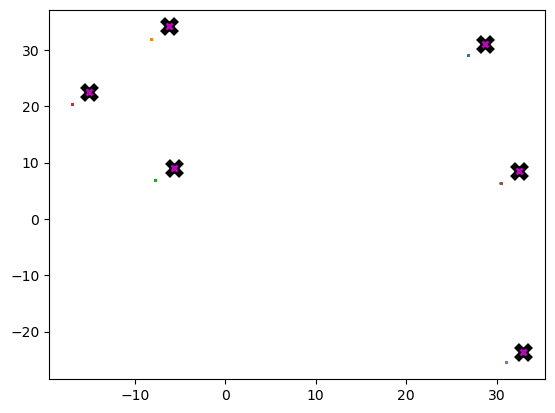

In [35]:
plot_data(centroids+2, X, n_samples)

## Animation

In [36]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [37]:
def do_one(d):
    if d: one_update(X)
    ax.clear()
    plot_data(centroids+2, X, n_samples, ax=ax)

In [38]:
# create your own animation
X = data.clone()
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

## GPU batched algorithm

To truly accelerate the algorithm, we need to be performing updates on a batch of points per iteration, instead of just one as we were doing.

In [39]:
# check GPU resources
print("GPU available?", torch.cuda.is_available())
print("How many GPUs?", torch.cuda.device_count())
torch.cuda.empty_cache() # clean cache

GPU available? True
How many GPUs? 1


In [ ]:
#!nvidia-smi # show system management interface

In [41]:
bs=5
X = data.clone()
x = X[:bs]
x.shape,X.shape

(torch.Size([5, 2]), torch.Size([1500, 2]))

In [42]:
def dist_b(a,b): return (((a[None]-b[:,None])**2).sum(2)).sqrt()

In [43]:
dist_b(X, x)

tensor([[ 0.000,  3.899,  4.834,  ..., 17.628, 22.610, 21.617],
        [ 3.899,  0.000,  4.978,  ..., 21.499, 26.508, 25.500],
        [ 4.834,  4.978,  0.000,  ..., 19.373, 24.757, 23.396],
        [ 3.726,  0.185,  4.969,  ..., 21.335, 26.336, 25.333],
        [ 6.273,  5.547,  1.615,  ..., 20.775, 26.201, 24.785]])

In [44]:
dist_b(X, x).shape

torch.Size([5, 1500])

In [45]:
X[None,:].shape, x[:,None].shape, (X[None,:]-x[:,None]).shape

(torch.Size([1, 1500, 2]), torch.Size([5, 1, 2]), torch.Size([5, 1500, 2]))

In [46]:
weight = gaussian(dist_b(X, x), 2)
weight

tensor([[    0.199,     0.030,     0.011,  ...,     0.000,     0.000,     0.000],
        [    0.030,     0.199,     0.009,  ...,     0.000,     0.000,     0.000],
        [    0.011,     0.009,     0.199,  ...,     0.000,     0.000,     0.000],
        [    0.035,     0.199,     0.009,  ...,     0.000,     0.000,     0.000],
        [    0.001,     0.004,     0.144,  ...,     0.000,     0.000,     0.000]])

In [47]:
weight.shape,X.shape

(torch.Size([5, 1500]), torch.Size([1500, 2]))

In [48]:
weight[...,None].shape, X[None].shape

(torch.Size([5, 1500, 1]), torch.Size([1, 1500, 2]))

In [49]:
num = (weight[...,None]*X[None]).sum(1)
num.shape

torch.Size([5, 2])

In [50]:
num

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.217],
        [231.302, 234.155]])

In [51]:
torch.einsum('ij,jk->ik', weight, X)

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.218],
        [231.302, 234.155]])

In [52]:
weight@X

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.218],
        [231.302, 234.155]])

In [53]:
div = weight.sum(1, keepdim=True)
div.shape

torch.Size([5, 1])

In [54]:
num/div

tensor([[26.376, 27.692],
        [26.101, 29.643],
        [28.892, 28.990],
        [26.071, 29.559],
        [29.323, 29.685]])

In [55]:
def meanshift(data, bs=500):
    n = len(data)
    X = data.clone()
    for it in range(5):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs,n))
            weight = gaussian(dist_b(X, X[s]), 2.5)
#             weight = tri(dist_b(X, X[s]), 8)
            div = weight.sum(1, keepdim=True)
            X[s] = weight@X/div
    return X

Although each iteration still has to launch a new cuda kernel, there are now fewer iterations, and the acceleration from updating a batch of points more than makes up for it.

In [56]:
data = data.cuda()

In [57]:
X = meanshift(data).cpu()

In [58]:
%timeit -n 5 _=meanshift(data, 1250).cpu()

912 µs ± 48.8 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


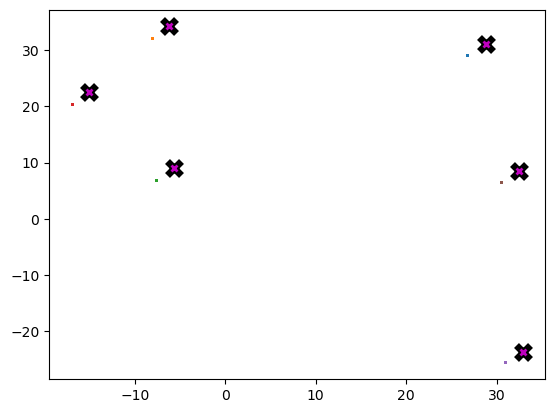

In [59]:
plot_data(centroids+2, X, n_samples)

*Video @ approx 1:34*

**Jeremy's Homework:** implement k-means clustering, dbscan, locality sensitive hashing, or some other clustering, fast nearest neighbors, or similar algorithm of your choice, on the GPU. Check if your version is faster than a pure python or CPU version.

Bonus: Implement it in APL too!

Super bonus: Invent a new meanshift algorithm which picks only the closest points, to avoid quadratic time.

Super super bonus: Publish a paper that describes it :D

# Homework: K-Means Clustering From Scratch

## Introduction to K-Means Clustering

The following text is copied from [wikipedia](https://en.wikipedia.org/wiki/K-means_clustering). 

Given a set of observations $\mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_n$, where each observation is a $d$-dimensional real vector, $k$-means clustering aims to partition the $n$ observations into $k$ $(k \leq n)$ sets $\mathbf{S} = \{ S_1, S_2, \ldots, S_k \}$ so as to minimize the within-cluster sum of squares (WCSS) (i.e. variance). Formally, the objective is to find:
\begin{equation}
    \operatorname{arg\,min}_\mathbf{S} \sum_{i=1}^{k} \sum_{\mathbf{x} \in S_i} \left\| \mathbf{x} - \boldsymbol{\mu}_i \right\|^2 = \operatorname{arg\,min}_\mathbf{S} \sum_{i=1}^k |S_i| \operatorname{Var}(S_i)
\end{equation}
where $\boldsymbol{\mu}_i$ is the mean (also called centroid) of points in $S_i$, i.e.
\begin{equation}
    \boldsymbol{\mu}_i = \frac{1}{|S_i|} \sum_{\mathbf{x} \in S_i} \mathbf{x},
\end{equation}
$|S_i|$ is the size of $S_i$, and $\|\cdot\|$ is the usual $L^2$ norm. This is equivalent to minimizing the pairwise squared deviations of points in the same cluster:
\begin{equation}
    \operatorname{arg\,min}_\mathbf{S} \sum_{i=1}^{k} \frac{1}{|S_i|} \sum_{\mathbf{x}, \mathbf{y} \in S_i} \left\| \mathbf{x} - \mathbf{y} \right\|^2
\end{equation}


**Standard Algorithm (Naive k-means)**

The most common algorithm uses an iterative refinement technique. Due to its ubiquity, it is often called "the k-means algorithm"; it is also referred to as Lloyd's algorithm, particularly in the computer science community. It is sometimes also referred to as "naïve k-means," because there exist much faster alternatives (1).

Given an initial set of $k$ means $m_1^{(1)}, \ldots, m_k^{(1)}$ (see below), the algorithm proceeds by alternating between two steps (2):

Assignment step: Assign each observation to the cluster with the nearest mean: that with the least squared Euclidean distance (3). Mathematically, this means partitioning the observations according to the Voronoi diagram generated by the means.
\begin{equation}
S_i^{(t)} = \left\{ x_p : \| x_p - m_i^{(t)} \|^2 \leq \| x_p - m_j^{(t)} \|^2 \ \forall j, 1 \leq j \leq k \right\},
\end{equation}
where each $x_p$ is assigned to exactly one $S^{(t)}$, even if it could be assigned to two or more of them.

Update step: Recalculate means (centroids) for observations assigned to each cluster.
\begin{equation}
m_i^{(t+1)} = \frac{1}{|S_i^{(t)}|} \sum_{x_j \in S_i^{(t)}} x_j
\end{equation}


The objective function in $k$-means is the WCSS (within-cluster sum of squares). After each iteration, the WCSS decreases and so we have a nonnegative monotonically decreasing sequence. This guarantees that $k$-means always converges, but not necessarily to the global optimum.

The algorithm has converged when the assignments no longer change or equivalently, when the WCSS has become stable. The algorithm is not guaranteed to find the optimum (4).

**References**

1. Pelleg, Dan; Moore, Andrew. "Accelerating exact k-means algorithms with geometric reasoning". Proceedings of the fifth ACM SIGKDD international conference on Knowledge discovery and data mining. ACM Press, 1999, pp. 277–281.
2. MacKay, David. "Information Theory, Inference and Learning Algorithms". Cambridge University Press, 2003, pp. 284–292.
3. Since the square root is a monotone function, this also is the minimum Euclidean distance assignment.
4. Hartigan, J. A.; Wong, M. A. "Algorithm AS 136: A k-Means Clustering Algorithm". Journal of the Royal Statistical Society, Series C, 1979, vol. 28, no. 1, pp. 100–108.

<div>
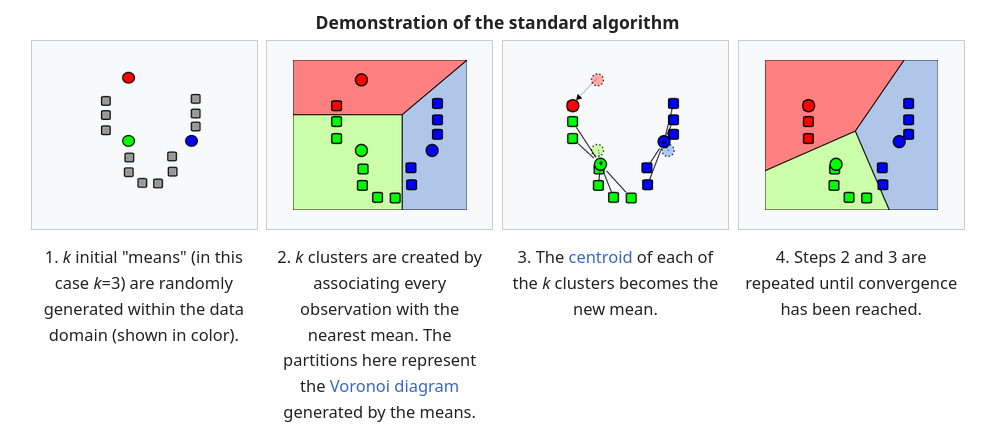
</div>


**Definitions:**

**Cluster:** A cluster is a collection of data points that are grouped together because they share certain similarities, often in terms of their proximity to each other. In k-means clustering, each data point in the dataset is assigned to one of the k clusters based on its distance to the centroids. A cluster is essentially a subset of the entire dataset.

**Centroid:** A centroid is a representative point of a cluster. It is the "center" of the cluster and is typically calculated as the mean (average) of all the points within that cluster. In each iteration of the k-means algorithm, the centroids are updated to be the new centers of their respective clusters based on the current assignments of points to clusters.

In [60]:
# Import type hints for code readability and documentation
from typing import List, Tuple
from torch import Tensor

## K-Means Clustering: Initial Implementation

### Initialize Centroids Using the Forgy Method

In this method, the centroids are randomly chosen from the actual data points. The function below essentially shuffles the indices of the points (random permutation) then picks the first k points. Note, there is no equivalent to random.sample in PyTorch.

In [61]:
def initialize_centroids(k, points):
    """
    Initializes centroids using the Forgy method.

    Parameters:
    k (int): The number of centroids to initialize.
    points (torch.Tensor): A tensor of shape (n, d) where n is the number of points and d is the dimensionality of each point.

    Returns:
    torch.Tensor: A tensor of shape (k, d) containing the initial centroids.
    """
    indx = torch.randperm(len(points))[:k]   
    return points[indx]

# we could also try centroids = torch.randn(k, points.shape[1])

In [62]:
# Put data back on CPU for now:
data = data.cpu()

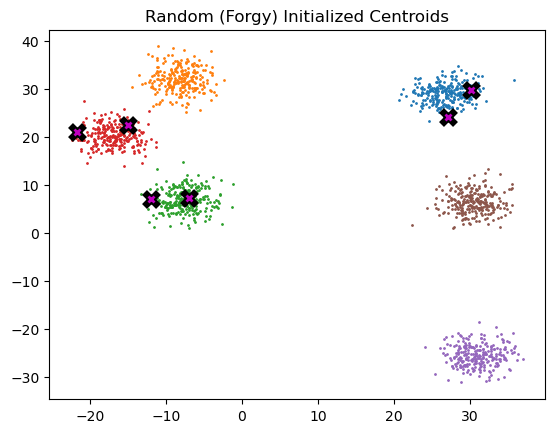

In [63]:
# Test to see if the Forgy method is working. The centroids appear to be correctly initialized.
k = 6
random_centroids = initialize_centroids(k, data)
plot_data(random_centroids, data, n_samples, title='Random (Forgy) Initialized Centroids')

### K-Means Clustering Algorithm Version 1.0

In [64]:
def distance(A, B): # Euclidian distance
    #return ((A-B)**2).sum(1).sqrt() # works fine. 
    return torch.norm(A - B, dim=1) # per docs, this may be deprecated in future

In [65]:
def k_means_cluster_v1(k, points, max_iters=20, tol=1e-08):
    # Initialize centroids: choose k centroids (Forgy, Random Partition, etc.)
    centroids = initialize_centroids(k, points)  # returns a tensor of shape k,d
    
    for iteration in range(max_iters):
        clusters = [[] for _ in range(k)] # initilize clusters 
              
        # Assign each point to the nearest centroid. The index of the points is stored in the 'clusters' list.
        for i, point in enumerate(points): # We may attempt to vectorize this loop later, using the batched distance function.
            distances_to_each_centroid = distance(point, centroids)
            cluster_assignment = torch.argmin(distances_to_each_centroid) # argmin returns the index of the min value (closest centroid)
            clusters[cluster_assignment].append(i)
        
        # Calculate new centroids
        new_centroids = torch.zeros_like(centroids)
        for idx, cluster in enumerate(clusters):
            if cluster:  # Avoid division by zero
                new_centroids[idx] = torch.mean(points[cluster], dim=0) # calculate new centroid as the mean of the cluster
            else:  # If a cluster is empty, re-initialize a single centroid for the cluster
                new_centroids[idx] = initialize_centroids(1, points)[0]
        
        # Test convergence
        if torch.allclose(new_centroids, centroids, atol=tol):  # default absolute tolerance for isclose is 1e-08 
            # print(f"Converged after {iteration + 1} iterations!")
            return clusters, new_centroids
        
        centroids = new_centroids
    
    # print(f"Reached maximum number of iterations: {max_iters}")
    return clusters, centroids # clusters returned for debugging purposes; can remove.

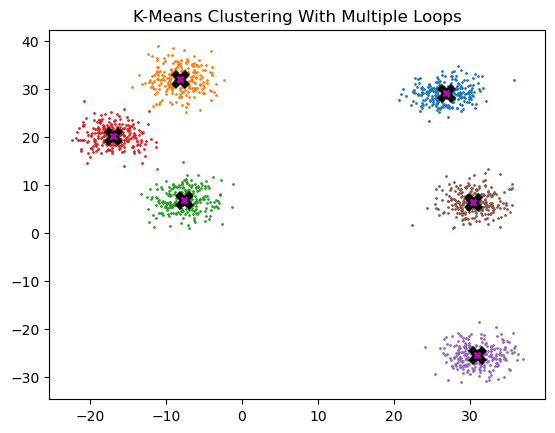

In [108]:
k = 6
clustering_test, final_centroids = k_means_cluster_v1(k, data)

# these tensors must be on .cpu() for plotting purposes
plot_data(final_centroids.cpu(), data.cpu(), n_samples, title='K-Means Clustering With Multiple Loops')

In [67]:
%timeit -n 5 _ = k_means_cluster_v1(k, data)
# Slow, typically at 200 to 300 ms per loop.

83.8 ms ± 10.2 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


## Animation of K-Means

Uses a modification of our basic function that creates a list to store the history of the centroids and clusters at each step.

In [68]:
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [69]:
# Function to plot data and centroids
def plot_data_k_means(ax, points, clusters, centroids):
    ax.clear()
    colors = ['r', 'y', 'g', 'b', 'c', 'm']  # Extend if needed
    for idx, cluster in enumerate(clusters):
        cluster_points = points[cluster]
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], c=colors[idx], s=1, label=f'Cluster {idx+1}')
    ax.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x', s=20, label='Centroid')
    ax.legend()
    ax.set_title('K-Means Clustering Animation')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')

In [70]:
# Modified k-means clustering to capture each iteration's state
def k_means_cluster_historic(k, points, max_iters=20):
    centroids = initialize_centroids(k, points)
    history = []

    for iteration in range(max_iters):
        clusters = [[] for _ in range(k)]
        
        for i, point in enumerate(points):
            distances_to_each_centroid = distance(point, centroids)
            cluster_assignment = torch.argmin(distances_to_each_centroid).item()
            clusters[cluster_assignment].append(i)
        
        new_centroids = torch.zeros_like(centroids)
        for idx, cluster in enumerate(clusters):
            if cluster:
                new_centroids[idx] = torch.mean(points[cluster], dim=0)
            else:
                new_centroids[idx] = initialize_centroids(1, points)[0]
        
        history.append((clusters, centroids)) 
        # Is tensor mutated in place? If so we should use centroids.clone() to store its state. 
        # Safer to use clusters.copy() too? Although these seem to work fine without.
        
        if torch.all(torch.isclose(new_centroids, centroids, atol=1e-08)):
            print(f"Converged after {iteration + 1} iterations!")
            break
        
        centroids = new_centroids

    history.append((clusters, centroids.clone())) #may be redundant?
    return clusters, centroids, history

In [71]:
# Function to animate k-means clustering
def animate_k_means(k, points, max_iters=20, interval=500):
    _, _, history = k_means_cluster_historic(k, points, max_iters)
    fig, ax = plt.subplots()
    
    def update(frame):
        clusters, centroids = history[frame]
        plot_data_k_means(ax, points, clusters, centroids)
    
    ani = FuncAnimation(fig, update, frames=len(history), interval=interval, repeat=False)
    plt.close()
    return HTML(ani.to_jshtml())

In [72]:
# Put data back on CPU for now (plotting function gives an error on GPU):
data = data.cpu()

# Display the animation
animation = animate_k_means(k, data, max_iters=20, interval=500)
animation

Converged after 8 iterations!


## Vectorizing GPU Batched K-Means Algorithm

Note to reader: Skip this part. I reproduced a little of Jeremy's work, vectorized (enabled batch processing) the calculation of distances, but ultimately moved on.

**Note:** Jeremy's plotting function only works on the CPU.

In [73]:
# Let's reproduce Jeremy's work above:
bs=5
X = data.clone()
x = X[:bs]
x.shape,X.shape

(torch.Size([5, 2]), torch.Size([1500, 2]))

In [74]:
def dist_b(a,b): return (((a[None]-b[:,None])**2).sum(2)).sqrt()

In [75]:
dist_b(X, x)

tensor([[ 0.000,  3.899,  4.834,  ..., 17.628, 22.610, 21.617],
        [ 3.899,  0.000,  4.978,  ..., 21.499, 26.508, 25.500],
        [ 4.834,  4.978,  0.000,  ..., 19.373, 24.757, 23.396],
        [ 3.726,  0.185,  4.969,  ..., 21.335, 26.336, 25.333],
        [ 6.273,  5.547,  1.615,  ..., 20.775, 26.201, 24.785]])

In [76]:
dist_b(x, X).shape

torch.Size([1500, 5])

Lets see if we can vectorize the following loop in our K-means algorithm:

```
clusters = [[] for _ in range(k)] # initilize clusters 
      
for i, point in enumerate(points): 
    distances_to_each_centroid = distance(point, centroids)
    cluster_assignment = torch.argmin(distances_to_each_centroid)
    clusters[cluster_assignment].append(i)

```

In [77]:
# First, we create a very simple list of points, with pre-defined centroids, so we can easily view results.
simple_points = torch.tensor([[1., 2.], [1., 4.], [1., 0.], [10., 2.], [10., 4.], [10., 0.]])
simple_centroids = torch.tensor([[10.5,  2.], [ 1.5,  2.]]) # x-offset by 0.5 for plotting

In [78]:
simple_points.shape, simple_centroids.shape

(torch.Size([6, 2]), torch.Size([2, 2]))

In [79]:
# Let's create a batch. Here of size 3 (points 0, 1, and 2).
batched_points = simple_points[:3]

In [80]:
batched_points.shape

torch.Size([3, 2])

The batched_points tensor has a shape of \[3,2], i.e., three (x,y) points. If we try to use our current distance function to calculate the distance to the centroids of shape \[2,2], i.e., two centroids located at (x,y), we will receive an error, specifically:

RuntimeError: The size of tensor a (3) must match the size of tensor b (2) at non-singleton dimension 0.

Let's modify the inputs to the distance function to ensure the sizes match on the appropriate dimensions.

In [81]:
# Testing to create an additional dimension, using None (equivalent to np.newaxis in NumPy).
#Alternatively, use torch.unsqueeze_(index_of_new_dimension).
print(batched_points[None].shape)
print(simple_centroids[:,None].shape) # None at index 1, to align the last dimensions correctly; [:,:,None] would be incorrect
# Shows we are nicely aligned at the last dimension [2]

torch.Size([1, 3, 2])
torch.Size([2, 1, 2])


In [82]:
def dist_batch(points, centroids): # Euclidian distance
    return (((points[None]) - (centroids[:,None]))**2).sum(2).sqrt() # sum over the last dimension (index [2])
    #return torch.norm(points[None] - centroids[:,None], dim=2) 
    # Einsum practice:
    #dif = points[None] - centroids[:,None]
    #return torch.einsum('ijk,ijk->ij', dif, dif).sqrt()
    
dist_batch(batched_points, simple_centroids)

tensor([[9.500, 9.708, 9.708],
        [0.500, 2.062, 2.062]])

In [83]:
# We will revise the following loop to incorporate batches.

clusters = [[] for _ in range(len(simple_centroids))]  # Initialize clusters list

for i, point in enumerate(simple_points):
    distances_to_each_centroid = distance(point, simple_centroids)
    cluster_assignment = torch.argmin(distances_to_each_centroid)
    clusters[cluster_assignment].append(i)

print(clusters)

[[3, 4, 5], [0, 1, 2]]


### Testing Assignment of Points to Clusters (in the For loop)

Let's test out our new code for running batches of points


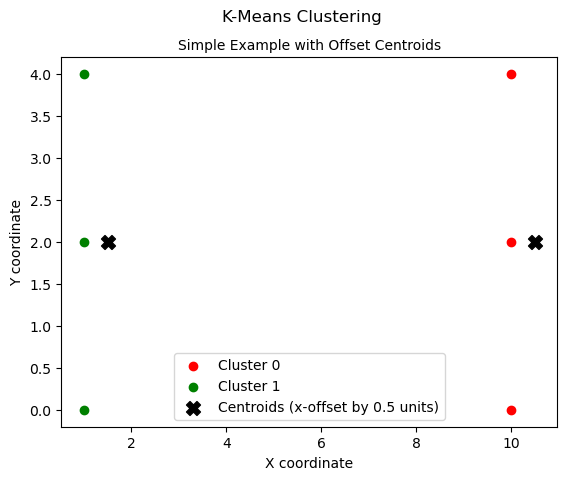

Cluster assignment for two centroids= [[3, 4, 5], [0, 1, 2]]


In [84]:
torch.set_default_device('cpu') # for plotting 

# Test of the clusters list
simple_points = torch.tensor([[1., 2.], [1., 4.], [1., 0.], [10., 2.], [10., 4.], [10., 0.]])
simple_centroids = torch.tensor([[10.5,  2.], [ 1.5,  2.]]) # x-offset by 0.5 for plotting

def distance(A, B):
    return ((A-B)**2).sum(1).sqrt() 

# Assign points to clusters based on distances to centroids
clusters = [[] for _ in range(len(simple_centroids))]  # Initialize clusters list

for i, point in enumerate(simple_points):
    distances_to_each_centroid = distance(point, simple_centroids)
    cluster_assignment = torch.argmin(distances_to_each_centroid)
    clusters[cluster_assignment].append(i)

# Plotting
colors = ['r', 'g', 'b', 'c', 'm', 'y']  
for cluster_idx, cluster in enumerate(clusters):
    cluster_points = simple_points[cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=colors[cluster_idx], label=f'Cluster {cluster_idx}')
    
# Plot centroids
plt.scatter(simple_centroids[:, 0], simple_centroids[:, 1], c='black', marker='X', s=100, label='Centroids (x-offset by 0.5 units)')

# Plot configuration
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Simple Example with Offset Centroids', fontsize=10)
plt.suptitle('K-Means Clustering',fontsize=12) # Actually a title. Matplotlib places the subtitle above the title!
plt.legend()
plt.show()

print('Cluster assignment for two centroids=', clusters)

### Running batches through the (vectorized) loop that calculates distances

Successfully completed. The two outputs match: [[3, 4, 5], [0, 1, 2]].

In [85]:
torch.set_default_device('cuda')
data = data.cuda()

k = len(simple_centroids) # k=2 for testing purposes (2 pre-specified centroids)
bs = 3
points = simple_points
n = len(points)
# add the following within a loop of max iters:

clusters = [[] for _ in range(k)]  # Initialize clusters list
print('empty clusters=', clusters)
for i in range (0, n, bs):
    s = slice(i, min(i+bs, n))
    print(s)
    distances_to_each_centroid = dist_batch(points[s], simple_centroids)
    print(distances_to_each_centroid)
    cluster_assignment = torch.argmin(distances_to_each_centroid, dim=0, keepdim=False) # bug here? dim = 1? Investigate.
    print(cluster_assignment)
    # OK, but now we are stuck with a For loop for cluster assignment.    
    for j, cluster_idx in enumerate(cluster_assignment):
        clusters[cluster_idx].append(i + j)
    print('completed iteration')
print('clusters variable =', clusters)

empty clusters= [[], []]
slice(0, 3, None)
tensor([[9.500, 9.708, 9.708],
        [0.500, 2.062, 2.062]])
tensor([1, 1, 1])
completed iteration
slice(3, 6, None)
tensor([[0.500, 2.062, 2.062],
        [8.500, 8.732, 8.732]])
tensor([0, 0, 0])
completed iteration
clusters variable = [[3, 4, 5], [0, 1, 2]]


OK, so the outputs are the same. We have (possibly) successfully batched the 'distance' calculations. However, we still have to loop through and do cluster assignment, and then calculate the means of the clusters (i.e., create centroids). To tackle the cluster assignment, we could store a list of cluster assignments outside the loop, then perform that after all batches are done. However, I'll take step back and see if there is a different approach. I think the code would become over-complicated if I were to continue with this line of thinking.

## K-Means Version 2.0

I asked ChatGPT to see if it could improve my code. For whatever reason, it took my batches out and came up with the following code (after some debugging, mainly related to variable type and dimension mismatches). 

In [86]:
torch.set_default_device('cuda')
gpu_data = data.clone().cuda()

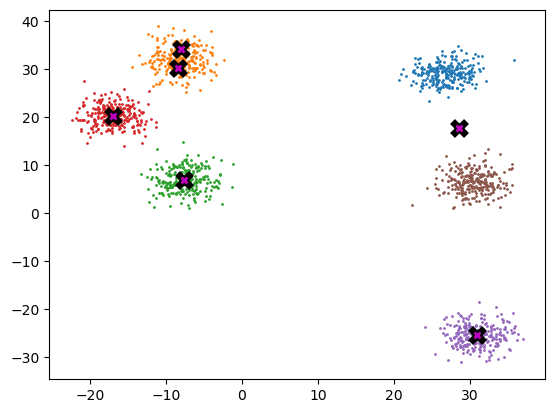

In [87]:
def dist_batch(points, centroids):
    # Calculate the distance from each point to each centroid
    return torch.cdist(points, centroids) # L2 norm by default (p=2.0) 

def k_means_cluster_v2(k, points, max_iters=20, tol=1e-08):
    centroids = initialize_centroids(k, points)  # returns a tensor of shape k,d
   
    for i in range(max_iters):
        distances_to_each_centroid = dist_batch(points, centroids)
        cluster_assignments = torch.argmin(distances_to_each_centroid, dim=1)

        # Debugging: Print shapes of relevant tensors
        #print(f"Shapes: cluster_assignments={cluster_assignments.shape}, points={points.shape}")

        cluster_sums = torch.zeros_like(centroids)
        cluster_counts = torch.zeros(k, dtype=torch.int32)
        
        # Debugging: Print cluster_assignments to check its values
        #print("Cluster Assignments:", cluster_assignments)

        for idx in range(k):
            assigned_points = points[cluster_assignments == idx]
            if len(assigned_points) > 0:
                cluster_sums[idx] = assigned_points.sum(dim=0)
                cluster_counts[idx] = assigned_points.shape[0]

        # Avoid division by zero
        mask = cluster_counts > 0
        new_centroids = torch.where(mask.unsqueeze(1), cluster_sums / cluster_counts.unsqueeze(1), centroids)

        if torch.allclose(new_centroids, centroids, atol=tol):
            #print(f"Converged after {i + 1} iterations!")
            break

        centroids = new_centroids
    
    #else:
        #print(f"Reached maximum number of iterations: {max_iters}")

    return centroids

final_centroids = k_means_cluster_v2(6, gpu_data)
plot_data(final_centroids.cpu(), data.cpu(), n_samples)

In [88]:
%timeit -n 5 _ = k_means_cluster_v2(k, gpu_data)

971 µs ± 167 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


This version is much quicker (on GPU at approx. 1-2 ms vs. 200-300 ms above). Note that the speeds often seem to depend on how many iterations are required for convergence. For a better test, we should take out the need for convergence and loop for a defined number of times (perhaps 5).

For fun, I asked ChatGPT if it could remove the loop over the range of k. Not sure if that is worthwhile, since k is usually low (6 in the example here), although the list of data points can be long. In any case, I was interested to learn a few more PyTorch functions.

## K-Means Version 3.0: An implementation using torch.scatter_()

The first algorithm it came up with suggested using torch.scatter_(). Further explanation on this function in the cells below. After fixing a few issues, we had a working version:

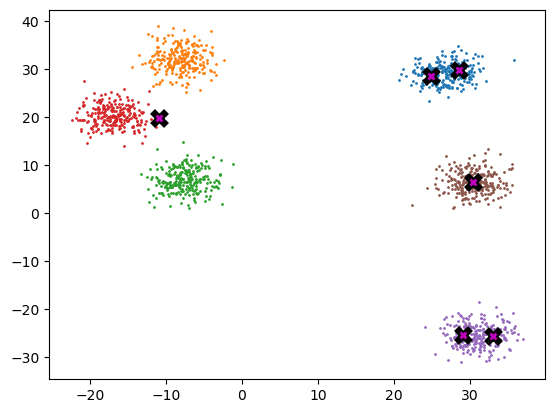

In [89]:
# Removed a For loop and replaced with .scatter_ function

def dist_batch(points, centroids):
    # Calculate the distance from each point to each centroid
    return torch.cdist(points, centroids) # L2 norm by default (p=2.0) 

def k_means_cluster_v3(k, points, max_iters=20, tol=1e-08):
    centroids = initialize_centroids(k, points)  # returns a tensor of shape (k, d)

    for _ in range(max_iters): # replace _ with i if not using print statements below
        distances_to_each_centroid = dist_batch(points, centroids)
        cluster_assignments = torch.argmin(distances_to_each_centroid, dim=1)

        # Debugging: Print shapes of relevant tensors
        #print(f"Shapes: cluster_assignments={cluster_assignments.shape}, points={points.shape}")

        # Create tensors to hold the sums of points and counts of points per cluster
        cluster_sums = torch.zeros_like(centroids)
        cluster_counts = torch.zeros(k, dtype=torch.int32)
        
        # Debugging: Print cluster_assignments to check its values
        #print("Cluster Assignments:", cluster_assignments)

        # Use scatter_add_ to sum points and count points per cluster
        cluster_sums.scatter_add_(0, cluster_assignments.unsqueeze(1).expand_as(points), points)
        cluster_counts.scatter_add_(0, cluster_assignments, torch.ones_like(cluster_assignments, dtype=torch.int32))

        # Equivalent code with scatter_reduce # However, no reason to use 'sum' when we have an option for 'mean'. See Version 3.1.
        #cluster_sums.scatter_reduce_(0, cluster_assignments.unsqueeze(1).expand_as(points), points, reduce="sum")
        #cluster_counts.scatter_reduce_(0, cluster_assignments, torch.ones_like(cluster_assignments, dtype=torch.int32), reduce="sum")

        # Original For loop:
        #for idx in range(k):
        #    assigned_points = points[cluster_assignments == idx]
        #    if len(assigned_points) > 0:
        #        cluster_sums[idx] = assigned_points.sum(dim=0)
        #        cluster_counts[idx] = assigned_points.shape[0]
        
        # Avoid division by zero 
        mask = cluster_counts > 0
        # Calculate new centroid as the mean of each cluster
        new_centroids = torch.where(mask.unsqueeze(1), cluster_sums / cluster_counts.unsqueeze(1), centroids)
        
        if torch.allclose(new_centroids, centroids, atol=tol):
            #print(f"Converged after {i + 1} iterations!")
            break

        centroids = new_centroids

    #else:
        #print(f"Reached maximum number of iterations: {max_iters}")

    return centroids

final_centroids = k_means_cluster_v3(6, gpu_data)
plot_data(final_centroids.cpu(), data.cpu(), n_samples)

In [90]:
torch.set_default_device('cuda')
%timeit -n 5 _ = k_means_cluster_v3(k, data.cuda())

769 µs ± 99.8 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [91]:
torch.set_default_device('cpu')
%timeit -n 5 _ = k_means_cluster_v3(k, data.cpu())

554 µs ± 87.7 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


Interesting. This version is actually slower on GPU than CPU. I suspect it's copying a lot of stuff back and forth, or I'm simply doing something wrong here!

**Explaining the code above**

ChatGTP provided the following explanation of the initial changes it made:

1. Cluster Sums: scatter_add_ is used to sum points assigned to each cluster.

```
cluster_sums.scatter_add_(0, cluster_assignments.unsqueeze(1).expand_as(points), points)
```

* cluster_assignments.unsqueeze(1).expand_as(points) creates an expanded index tensor to match the dimensions of points.

* scatter_add_ adds the points to the corresponding clusters based on cluster_assignments.

2. Cluster Counts: scatter_add_ is also used to count points in each cluster.

```
cluster_counts.scatter_add_(0, cluster_assignments, torch.ones_like(cluster_assignments, dtype=torch.int32))
```
* Here, we scatter ones into cluster_counts to count the number of points assigned to each cluster.


To understand torch.scatter_() and related functions, I suggest the following blog post. The PyTorch documentation is somewhat difficult to understand.

https://yuyangyy.medium.com/understand-torch-scatter-b0fd6275331c

After reviewing the documentation, I noticed that scatter_reduce has an option to return the mean. Instead of performing sums / counts to create the average, let's try do this directly with scatter_reduce.

From the documentation:
```
Tensor.scatter_reduce_(dim, index, src, reduce, *, include_self=True) → Tensor
```
Reduces all values from the src tensor to the indices specified in the index tensor in the self tensor using the applied reduction defined via the reduce argument ("sum", "prod", "mean", "amax", "amin"). For each value in src, it is reduced to an index in self which is specified by its index in src for dimension != dim and by the corresponding value in index for dimension = dim. If include_self="True", the values in the self tensor are included in the reduction.

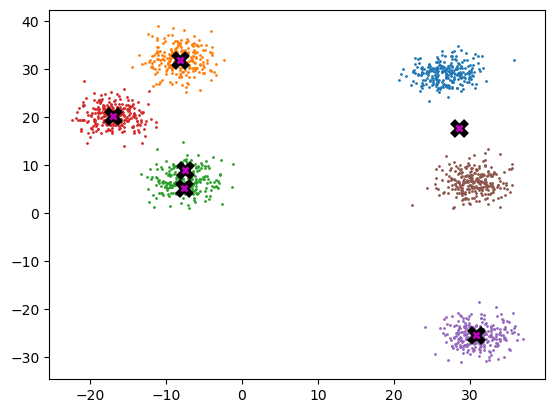

In [92]:
# Using the scatter_reduce 'mean' argument

def k_means_cluster_v3_1(k, points, max_iters=20, tol=1e-08):
    centroids = initialize_centroids(k, points)

    for _ in range(max_iters):  
        distances_to_each_centroid = dist_batch(points, centroids)
        cluster_assignments = torch.argmin(distances_to_each_centroid, dim=1)
        cluster_means = torch.zeros_like(centroids)
        cluster_means.scatter_reduce_(0, cluster_assignments.unsqueeze(1).expand_as(points), points, reduce="mean")

        if torch.allclose(cluster_means, centroids, atol=tol):
            break

        centroids = cluster_means
        
    return centroids

torch.set_default_device('cuda')
final_centroids = k_means_cluster_v3_1(6, gpu_data)
plot_data(final_centroids.cpu(), data.cpu(), n_samples)

In [93]:
torch.set_default_device('cuda')
%timeit -n 5 _ = k_means_cluster_v3_1(k, data.cuda())

669 µs ± 147 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [94]:
torch.set_default_device('cpu')
%timeit -n 5 _ = k_means_cluster_v3_1(k, data.cpu())

459 µs ± 45.3 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


Well, that is about the same, maybe slightly quicker, and the code looks cleaner too. 

# 3D Clustering

I was curious to see if this algorithm would work in more than 2 dimensions. First, we'll create some data and figure out matplotlib 3D plotting.

## Create data with x,y, and z axis

In [95]:
n_xyz_clusters=6
n_samples_per_cluster =250

xyz_centroids = torch.rand(n_xyz_clusters, 3)*70-35 # creates uniform random variable between -35 and 35.
xyz_centroids.shape

torch.Size([6, 3])

In [96]:
def sample_from_distribution(mean: Tensor, n_samples: int) -> Tensor:
    """
    Generates samples from a multivariate normal distribution.

    Parameters:
        mean (Tensor): A tensor of shape 3 representing a mean vector
        n_samples (int): The number of samples to generate.

    Returns:
        Tensor: A tensor of shape (n_samples, 3) containing the generated samples.
    """
    # Create a 3x3 diagonal covariance matrix with variances [5., 5., 5.]
    cov_matrix = torch.diag(torch.tensor([5., 5., 5.]))
    
    # Create a multivariate normal distribution with the given mean vector and covariance matrix
    distribution = MultivariateNormal(mean, cov_matrix)
    
    # Generate and return samples from the distribution
    return distribution.sample((n_samples,))

In [97]:
new_slices = [sample_from_distribution(c, n_samples_per_cluster) for c in xyz_centroids]
xyz_data = torch.cat(new_slices)
xyz_data.shape

torch.Size([1500, 3])

## Plot 3D data

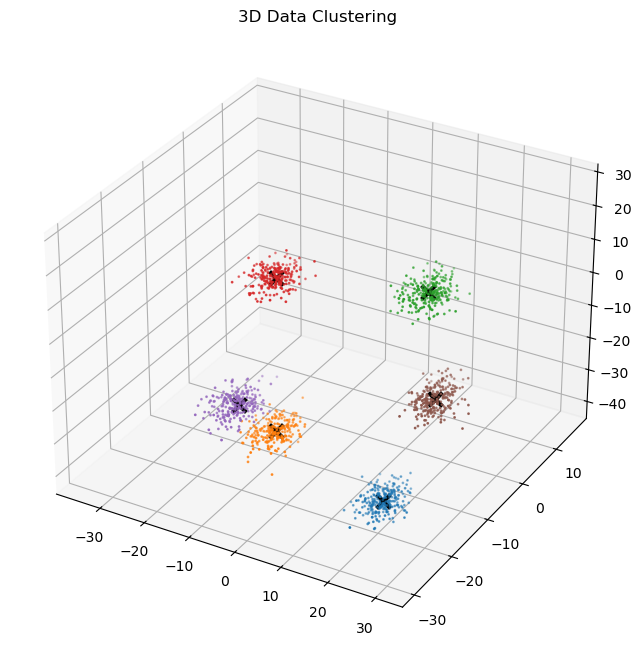

In [98]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_data(centroids, data, n_samples, ax=None, title=None): 
    """
    Plot 3D data points and centroids.
    """
    if ax is None:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
    
    for i, centroid in enumerate(centroids):
        samples = data[i * n_samples:(i + 1) * n_samples]
        ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2], s=1)
    
    for centroid in centroids:
        ax.scatter(*centroid, s=100, marker="x", color='k', linewidths=3, zorder=10)  # attempt to plot centroids on top; not well.
        # Note that *centroid unpacks the 3D coordinate (i.e., x, y, z) from the iterable
    if title:
        ax.set_title(title)

plot_3d_data(xyz_centroids.cpu(), xyz_data.cpu(), n_samples_per_cluster, title="3D Data Clustering")

## K-Means Clustering in 3D 

In [99]:
test_data = xyz_data.clone()

In [100]:
def initialize_centroids(k, points):
    # See documentation above. Forgy method of initialization.
    indx = torch.randperm(len(points))[:k]   
    return points[indx]

In [101]:
def dist_batch(points, centroids):
    # Same as function defined above.
    return torch.cdist(points, centroids) # L2 norm by default (p=2.0) 

In [102]:
# Same function as version 3.1 above. Copied here in case modification is needed.
def k_means_cluster(k, points, max_iters=20, tol=1e-08):
    centroids = initialize_centroids(k, points)

    for _ in range(max_iters):  
        distances_to_each_centroid = dist_batch(points, centroids)
        cluster_assignments = torch.argmin(distances_to_each_centroid, dim=1)
        cluster_means = torch.zeros_like(centroids)
        cluster_means.scatter_reduce_(0, cluster_assignments.unsqueeze(1).expand_as(points), points, reduce="mean")

        if torch.allclose(cluster_means, centroids, atol=tol):
            break

        centroids = cluster_means
    return centroids

In [103]:
final_3D_centroids = k_means_cluster(6, test_data); final_3D_centroids

tensor([[ 14.190,   2.650, -30.780],
        [ 24.511, -13.043,  20.713],
        [ 21.041, -20.131, -34.454],
        [-27.653,   9.463, -16.193],
        [ -8.283, -13.172, -33.587],
        [-12.459, -18.228, -21.804]])

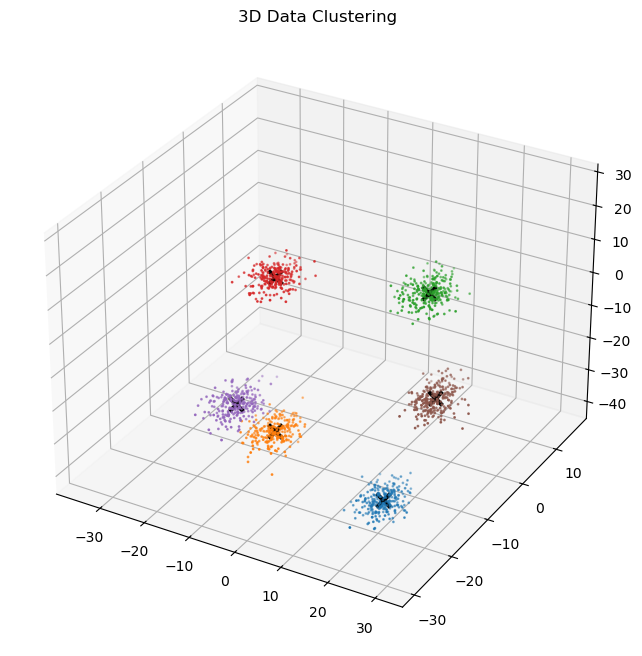

In [104]:
plot_3d_data(final_3D_centroids, xyz_data, n_samples_per_cluster, title="3D Data Clustering")

## Results 

The 3D clustering appears to be successful, without any modifications to the k-means function. I'm actually surprised it worked without giving me a dimension mismatch error, or at least it seems to work. 

Note that the code has not been tested much. It would really benefit from some checks.

# Homework Conclusion

The final K-means clustering function is shown below. I modified version 3.1 to return the cluster assignments too. The part that updates the centroids is a little hard to follow, unless you're a PyTorch scatter() wizard, and was written by ChatGPT for the most part, with some debugging and additional prompting to get it to use `reduce='mean'`. I guess you can call that cheating on the homework, but this really was a learning exercise for me in using PyTorch. Version 1 was written from scratch, but runs a little slower. 

In [105]:
def k_means_cluster(k: int, points: torch.Tensor, max_iters: int = 20, tol: float = 1e-08) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Perform k-means clustering on a set of points.

    Parameters:
        k (int): The number of clusters.
        points (torch.Tensor): The data points to cluster, of shape (N, D), where N is the number of points
                               and D is the dimensionality of each point.
        max_iters (int, optional): The maximum number of iterations for the k-means algorithm. Default is 20.
        tol (float, optional): The tolerance to consider convergence. Default is 1e-08.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: A tuple containing the centroids of the clusters (of shape (k, D))
                                           and the cluster labels for each data point (of shape (N,)).
    """
    centroids = initialize_centroids(k, points)

    for _ in range(max_iters):
        # Calculate distances to each centroid
        distances_to_each_centroid = dist_batch(points, centroids)
        
        # Assign points to the nearest centroid
        cluster_assignments = torch.argmin(distances_to_each_centroid, dim=1)
        
        # Update centroids as the mean of the points assigned to each cluster
        cluster_means = torch.zeros_like(centroids)
        cluster_means.scatter_reduce_(0, cluster_assignments.unsqueeze(1).expand_as(points), points, reduce="mean")

        # Check for convergence
        if torch.allclose(cluster_means, centroids, atol=tol):
            break

        centroids = cluster_means

    return centroids, cluster_assignments

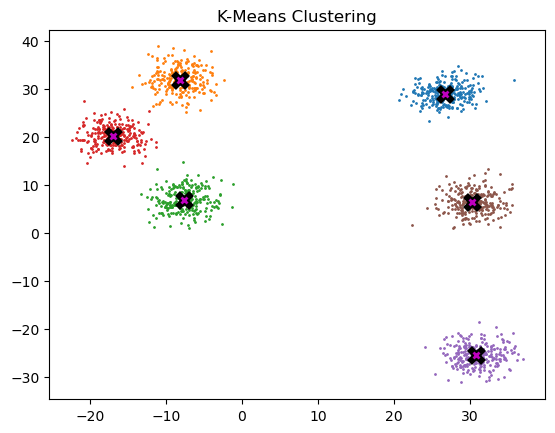

In [110]:
final_centroids, _ = k_means_cluster(6, gpu_data)
plot_data(final_centroids.cpu(), data.cpu(), n_samples, title='K-Means Clustering')